In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
import gseapy as gp
import anndata
from scipy import stats
from eval_utils import *
from plot_utils import *
sns.set_style('whitegrid')

#### Brief exploration seeds 4 and 5

In [741]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
dataset = 'Norman2019'
seeds = [4, 5]
methods = ['cpa', 'gears','nonctl-mean', 'matching-mean']

In [742]:
results_df = pd.DataFrame(
    columns=["method", "pert", "seed", "corr_all", "corr_20de",
             "corr_all_allpert", "corr_20de_allpert", "corr_all_twopert", "corr_20de_twopert",
             "mse_all", "mse_20de", "mse_all_allpert", "mse_20de_allpert",
             "jaccard", "jaccard_allpert", "one gene", "train"]
)
avg_pert_centroids = 'centroids'
for seed in seeds:
    file = f'../data/{dataset.lower()}/{dataset.lower()}_{seed}.h5ad'
    adata = anndata.read_h5ad(file)

    # Get control mean, non control mean (pert_mean), and non control mean differential
    train_adata = adata[adata.obs['split'] == 'train']
    control_adata = train_adata[train_adata.obs['control'] == 1]
    pert_adata = train_adata[train_adata.obs['control'] == 0]
    control_mean = np.array(control_adata.X.mean(axis=0))[0]    
    if avg_pert_centroids == 'centroids':
        pert_mean = average_of_perturbation_centroids(pert_adata)
    elif avg_pert_centroids == 'two pert centroids':
        pert_mean = average_of_perturbation_centroids(pert_adata[~pert_adata.obs['condition'].str.contains('ctrl')])
    else:
        pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
    
    two_pert_mean = np.array(pert_adata[~pert_adata.obs['condition'].str.contains('ctrl')].X.mean(axis=0))[0]
    for method in tqdm(methods):
        post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
        post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
        conditions = post_gt_df.index.get_level_values('condition').unique()
        for condition in conditions:
            gene_list = condition.split("+")
            one_gene = False
            if "ctrl" in gene_list:
                gene_list.remove("ctrl")
                one_gene = True
            one_gene_str = "1-gene" if one_gene else "2-gene"

            # Get data
            X_true = post_gt_df.loc[condition].values[0]
            X_pred = post_pred_df.loc[condition].values[0]
            delta_true = X_true - control_mean
            delta_pred = X_pred - control_mean
            delta_true_allpert = X_true - pert_mean
            delta_pred_allpert = X_pred - pert_mean
            delta_true_twopert = X_true - two_pert_mean
            delta_pred_twopert = X_pred - two_pert_mean
            n_train = post_gt_df.loc[condition].index.get_level_values('n_train').values[0]

            # Get top 20 DE genes
            adata_condition = adata[adata.obs["condition"] == condition]

            # Select top 20 DE genes
            top20_de_genes = adata.uns["top_non_dropout_de_20"][
                adata_condition.obs["condition_name"].values[0]
            ]
            top20_de_idxs = np.argwhere(
                np.isin(adata.var.index, top20_de_genes)
            ).ravel()

            top20_de_idxs_pred = get_topk_de_gene_ids(control_mean, X_pred, k=20)
            
            # Select top 20 DE genes (all pert)
            top20_de_genes_allpert = uns["top_non_dropout_de_20_allpert"][
                adata_condition.obs["condition_name"].values[0]
            ]
            top20_de_idxs_allpert = np.argwhere(
                np.isin(adata.var.index, top20_de_genes_allpert)
            ).ravel()
            top20_de_idxs_pred_allpert = get_topk_de_gene_ids(pert_mean, X_pred, k=20)
            
            # Store results
            results_df.loc[len(results_df)] = [
                    method,
                    condition,
                    seed,
                    pearsonr(delta_true, delta_pred)[0],
                    pearsonr(delta_true[top20_de_idxs], delta_pred[top20_de_idxs])[0],
                    pearsonr(delta_true_allpert, delta_pred_allpert)[0],
                    pearsonr(delta_true_allpert[top20_de_idxs], delta_pred_allpert[top20_de_idxs])[0],
                    pearsonr(delta_true_twopert, delta_pred_twopert)[0],
                    pearsonr(delta_true_twopert[top20_de_idxs], delta_pred_twopert[top20_de_idxs])[0],
                    np.mean((delta_true - delta_pred)**2),
                    np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                    np.mean((delta_true_allpert - delta_pred_allpert)**2),
                    np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                    jaccard_similarity(top20_de_idxs, top20_de_idxs_pred),
                    jaccard_similarity(top20_de_idxs_allpert, top20_de_idxs_pred_allpert),
                    one_gene_str,
                    n_train,
                ]

100%|████████████████████████████████████████████| 4/4 [00:08<00:00,  2.23s/it]


In [77]:
# Calculate RMSE
results_df['rmse_all'] = np.sqrt(results_df['mse_all'])
results_df['rmse_20de'] = np.sqrt(results_df['mse_20de'])
results_df['rmse_all_allpert'] = np.sqrt(results_df['mse_all_allpert'])
results_df['rmse_20de_allpert'] = np.sqrt(results_df['mse_20de_allpert'])

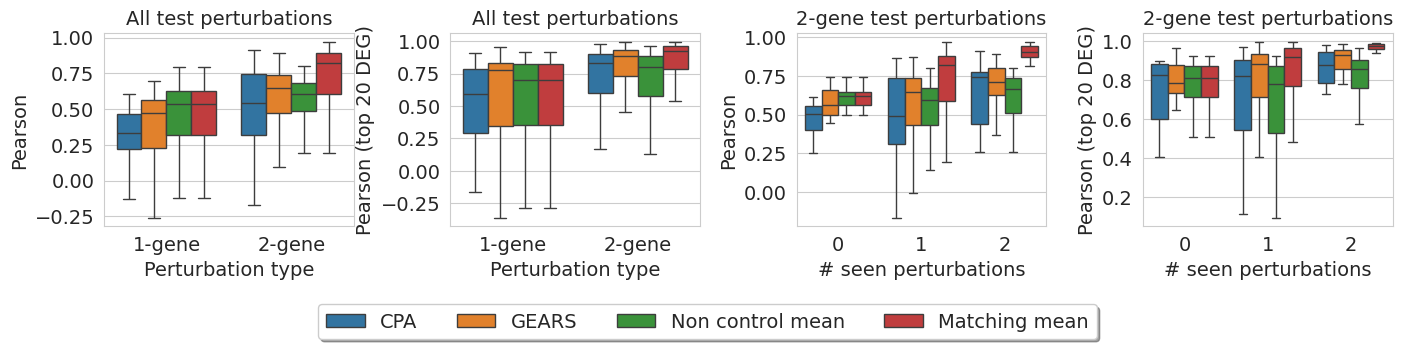

In [743]:
nrows = 1
ncols = 4
fontsize = 14
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(14, 3))
plt.subplot(nrows, ncols, 1)
# letter_annotation(plt.gca(), -.25, 1, 'a')
ax = sns.boxplot(data=results_df, x='one gene', y='corr_all', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
# letter_annotation(plt.gca(), -.25, 1, 'b')
ax = sns.boxplot(data=results_df, x='one gene', y='corr_20de', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 3)
# letter_annotation(plt.gca(), -.25, 1, 'd')
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
# letter_annotation(plt.gca(), -.25, 1, 'e')
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_20de', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=14)

labels=['CPA', 'GEARS', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
# plt.savefig(f'{figdir}/{dataset}_pearsondiff_combined_2.pdf', bbox_inches='tight');

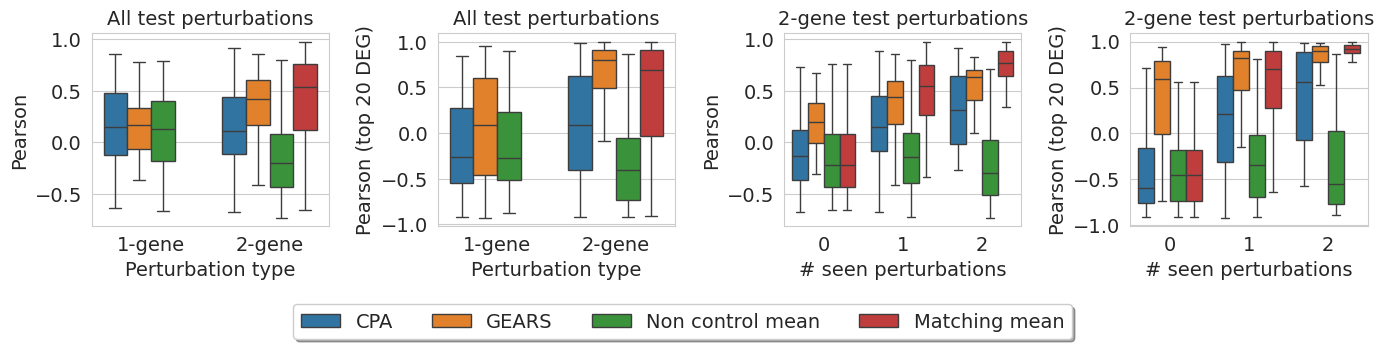

In [744]:
nrows = 1
ncols = 4
fontsize = 14
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(14, 3))
plt.subplot(nrows, ncols, 1)
# letter_annotation(plt.gca(), -.25, 1, 'a')
ax = sns.boxplot(data=results_df_, x='one gene', y='corr_all_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
# print(ax), [results_df['method'] != 'matching-mean']
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
# letter_annotation(plt.gca(), -.25, 1, 'b')
ax = sns.boxplot(data=results_df_, x='one gene', y='corr_20de_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 3)
# letter_annotation(plt.gca(), -.25, 1, 'd')
ax = sns.boxplot(data=results_df_[results_df_['one gene'] == '2-gene'], x='train', y='corr_all_allpert', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
# letter_annotation(plt.gca(), -.25, 1, 'e')
ax = sns.boxplot(data=results_df_[results_df_['one gene'] == '2-gene'], x='train', y='corr_20de_allpert', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=14)

labels=['CPA', 'GEARS', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
# plt.savefig(f'{figdir}/{dataset}_pearsondiff_allpert_combined_3.pdf', bbox_inches='tight');

#### Compute metrics, all seeds

In [7]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
dataset = 'Norman2019'
seeds = [1, 2, 3]
methods = ['cpa', 'gears', 'scgpt', 'scgpt_ft', 'nonctl-mean', 'matching-mean']

In [ ]:
file = f'../data/{dataset.lower()}/{dataset.lower()}_1.h5ad'
adata = anndata.read_h5ad(file)
adata_pert = adata[adata.obs['control'] == 0].copy()
adata_pert.X = adata_pert.X.toarray()

#compute DEGs
sc.tl.rank_genes_groups(
    adata_pert,
    groupby='condition_name',
    reference='rest',
    rankby_abs=True,
    n_genes=None,
    use_raw=False
)

In [11]:
adata_pert = adata[adata.obs['control'] == 0].copy()
genes_dict = rank_genes_groups_allpert(adata_pert)
adata.uns['rank_genes_groups_cov_allpert'] = genes_dict

# Get non dropout top 20 DEG
get_dropout_non_zero_genes_allpert(adata)
uns = adata.uns.copy()

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFram

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFr

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFr

In [12]:
results_df = pd.DataFrame(
    columns=["method", "pert", "seed", "corr_all", "corr_20de",
             "corr_all_allpert", "corr_20de_allpert", "corr_all_twopert", "corr_20de_twopert",
             "mse_all", "mse_20de", "mse_all_allpert", "mse_20de_allpert",
             "jaccard", "jaccard_allpert", "one gene", "train"]
)
avg_pert_centroids = 'centroids'
for seed in seeds:
    file = f'../data/{dataset.lower()}/{dataset.lower()}_{seed}.h5ad'
    adata = anndata.read_h5ad(file)

    # Get control mean, non control mean (pert_mean), and non control mean differential
    train_adata = adata[adata.obs['split'] == 'train']
    control_adata = train_adata[train_adata.obs['control'] == 1]
    pert_adata = train_adata[train_adata.obs['control'] == 0]
    control_mean = np.array(control_adata.X.mean(axis=0))[0]    
    if avg_pert_centroids == 'centroids':
        pert_mean = average_of_perturbation_centroids(pert_adata)
    elif avg_pert_centroids == 'two pert centroids':
        pert_mean = average_of_perturbation_centroids(pert_adata[~pert_adata.obs['condition'].str.contains('ctrl')])
    else:
        pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
    
    two_pert_mean = np.array(pert_adata[~pert_adata.obs['condition'].str.contains('ctrl')].X.mean(axis=0))[0]
    for method in tqdm(methods):
        post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
        post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
        conditions = post_gt_df.index.get_level_values('condition').unique()
        for condition in conditions:
            gene_list = condition.split("+")
            one_gene = False
            if "ctrl" in gene_list:
                gene_list.remove("ctrl")
                one_gene = True
            one_gene_str = "1-gene" if one_gene else "2-gene"

            # Get data
            X_true = post_gt_df.loc[condition].values[0]
            X_pred = post_pred_df.loc[condition].values[0]
            delta_true = X_true - control_mean
            delta_pred = X_pred - control_mean
            delta_true_allpert = X_true - pert_mean
            delta_pred_allpert = X_pred - pert_mean
            delta_true_twopert = X_true - two_pert_mean
            delta_pred_twopert = X_pred - two_pert_mean
            n_train = post_gt_df.loc[condition].index.get_level_values('n_train').values[0]

            # Get top 20 DE genes
            adata_condition = adata[adata.obs["condition"] == condition]

            # Select top 20 DE genes
            top20_de_genes = adata.uns["top_non_dropout_de_20"][
                adata_condition.obs["condition_name"].values[0]
            ]
            top20_de_idxs = np.argwhere(
                np.isin(adata.var.index, top20_de_genes)
            ).ravel()

            top20_de_idxs_pred = get_topk_de_gene_ids(control_mean, X_pred, k=20)
            
            # Select top 20 DE genes (all pert)
            top20_de_genes_allpert = uns["top_non_dropout_de_20_allpert"][
                adata_condition.obs["condition_name"].values[0]
            ]
            top20_de_idxs_allpert = np.argwhere(
                np.isin(adata.var.index, top20_de_genes_allpert)
            ).ravel()
            top20_de_idxs_pred_allpert = get_topk_de_gene_ids(pert_mean, X_pred, k=20)
            
            # Store results
            results_df.loc[len(results_df)] = [
                    method,
                    condition,
                    seed,
                    pearsonr(delta_true, delta_pred)[0],
                    pearsonr(delta_true[top20_de_idxs], delta_pred[top20_de_idxs])[0],
                    pearsonr(delta_true_allpert, delta_pred_allpert)[0],
                    pearsonr(delta_true_allpert[top20_de_idxs], delta_pred_allpert[top20_de_idxs])[0],
                    pearsonr(delta_true_twopert, delta_pred_twopert)[0],
                    pearsonr(delta_true_twopert[top20_de_idxs], delta_pred_twopert[top20_de_idxs])[0],
                    np.mean((delta_true - delta_pred)**2),
                    np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                    np.mean((delta_true_allpert - delta_pred_allpert)**2),
                    np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                    jaccard_similarity(top20_de_idxs, top20_de_idxs_pred),
                    jaccard_similarity(top20_de_idxs_allpert, top20_de_idxs_pred_allpert),
                    one_gene_str,
                    n_train,
                ]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.56s/it]


In [14]:
results_df.groupby('method')[['corr_all', 'corr_20de']].mean()

,corr_all,corr_20de
method,,
cpa,0.391117,0.562834
gears,0.537231,0.723025
matching-mean,0.653069,0.731928
nonctl-mean,0.535293,0.620818
scgpt,0.572740,0.650291
scgpt_ft,0.525951,0.685408


In [170]:
# Store results
# results_df.to_csv(f'{outdir}/{dataset}_all_results.csv')

#### Combined figure

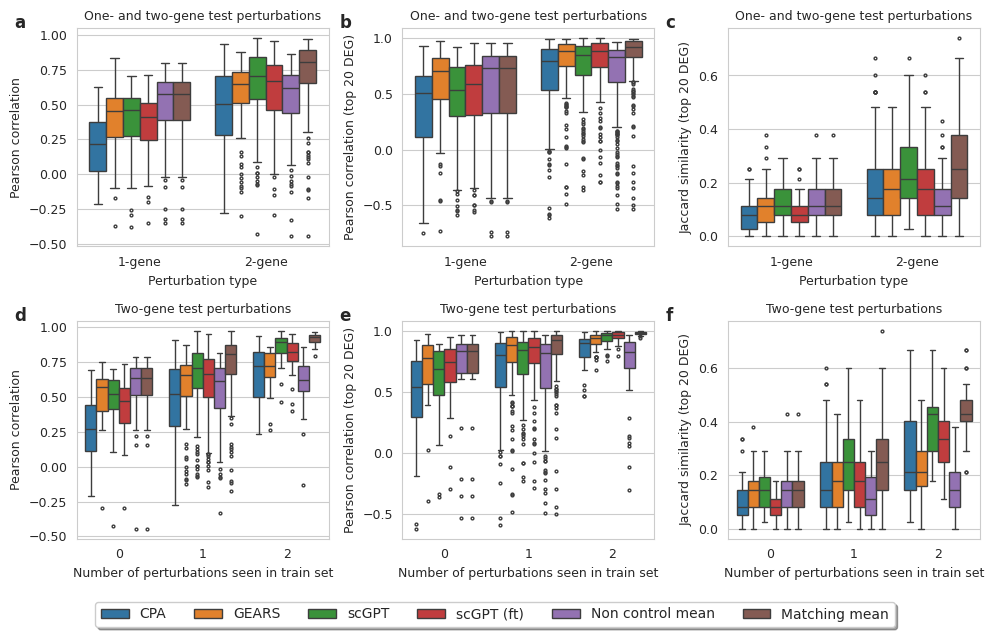

In [484]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.25, 1, 'a')
sns.boxplot(data=results_df, x='one gene', y='corr_all', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.25, 1, 'b')
sns.boxplot(data=results_df, x='one gene', y='corr_20de', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1, 'c')
sns.boxplot(data=results_df, x='one gene', y='jaccard', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
letter_annotation(plt.gca(), -.25, 1, 'd')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 5)
letter_annotation(plt.gca(), -.25, 1, 'e')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_20de', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 6)
letter_annotation(plt.gca(), -.25, 1, 'f')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='jaccard', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=6)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_pearsondiff_combined.pdf', bbox_inches='tight');

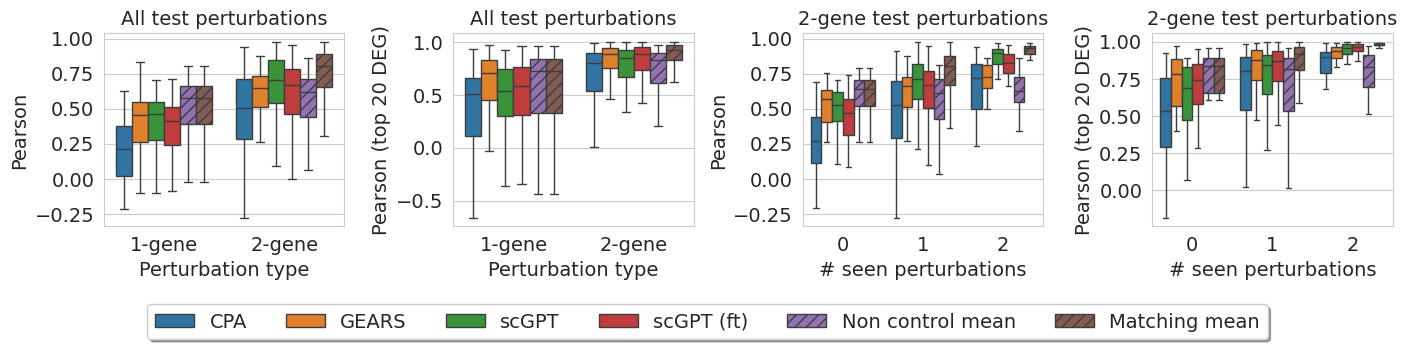

In [560]:
nrows = 1
ncols = 4
fontsize = 14
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(14, 3))
plt.subplot(nrows, ncols, 1)
# letter_annotation(plt.gca(), -.25, 1, 'a')
ax = sns.boxplot(data=results_df, x='one gene', y='corr_all', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
# letter_annotation(plt.gca(), -.25, 1, 'b')
ax = sns.boxplot(data=results_df, x='one gene', y='corr_20de', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 3)
# letter_annotation(plt.gca(), -.25, 1, 'd')
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
# letter_annotation(plt.gca(), -.25, 1, 'e')
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_20de', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=14)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_pearsondiff_combined_2.pdf', bbox_inches='tight');

In [631]:
results_df['train'].value_counts(), results_df_2['train'].value_counts()

(train
 0    882
 1    882
 2    234
 Name: count, dtype: int64,
 train
 0      882
 1      882
 all    648
 2      234
 Name: count, dtype: int64)

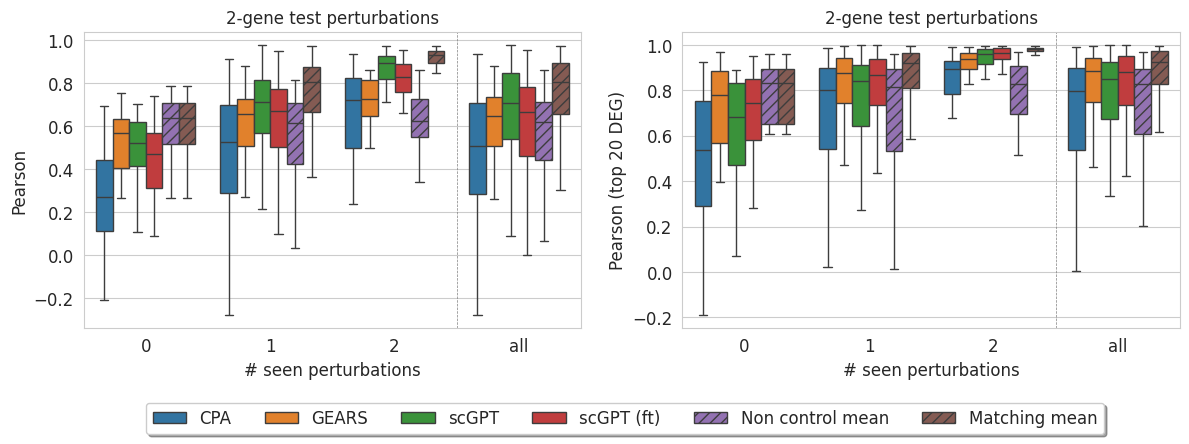

In [689]:
results_df_2 = results_df.copy()
results_df_2 = results_df_2[results_df_2['one gene'] == '2-gene']
results_df_2['train'] = 'all'
results_df_2 = pd.concat([results_df, results_df_2], axis=0)

nrows = 1
ncols = 2
fontsize = 12
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(12, 4))

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 1)
# letter_annotation(plt.gca(), -.25, 1, 'd')
ax = sns.boxplot(data=results_df_2[results_df_2['one gene'] == '2-gene'], x='train', y='corr_all', hue='method',
                 order=['0', '1', '2', 'all'],
                 fliersize=fliersize,
                 showfliers=showfliers,
                 hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
ax.axvline(ax.get_xticks()[-2]+.5, color='gray', linestyle='--', linewidth=0.5)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 2)
# letter_annotation(plt.gca(), -.25, 1, 'e')
ax = sns.boxplot(data=results_df_2[results_df_2['one gene'] == '2-gene'], x='train', y='corr_20de', hue='method',
                                  order=['0', '1', '2', 'all'],
                                  fliersize=fliersize,
                                  showfliers=showfliers,
                                  hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
ax.axvline(ax.get_xticks()[-2]+.5, color='gray', linestyle='--', linewidth=0.5)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize) # , labelpad=-10)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.525, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=12)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout(w_pad=2)
plt.savefig(f'{figdir}/{dataset}_pearsondiff_combined_3.pdf', bbox_inches='tight');

In [695]:
df_ = results_df[results_df['method'] == 'cpa']
df_[df_['one gene'] == '2-gene']['train'].value_counts()

train
1    147
2     39
0     39
Name: count, dtype: int64

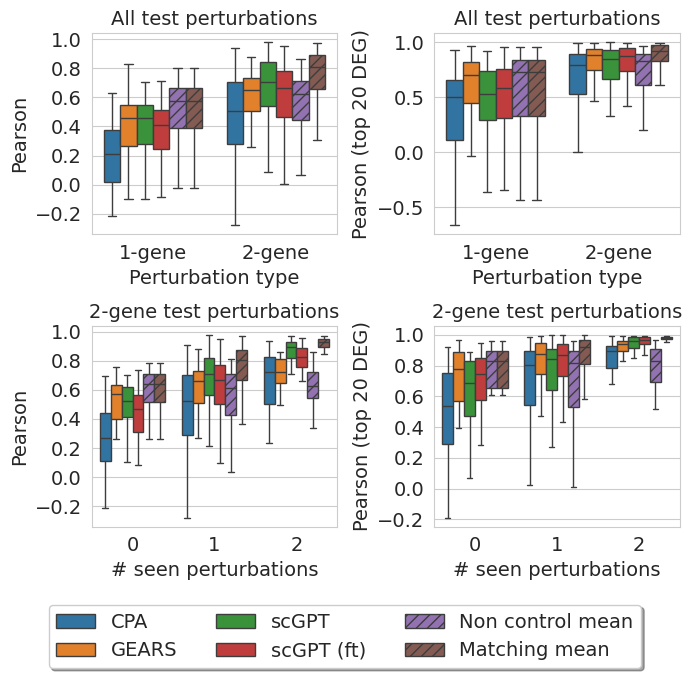

In [566]:
nrows = 2
ncols = 2
fontsize = 14
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(7, 6))
plt.subplot(nrows, ncols, 1)
# letter_annotation(plt.gca(), -.25, 1, 'a')
ax = sns.boxplot(data=results_df, x='one gene', y='corr_all', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
# letter_annotation(plt.gca(), -.25, 1, 'b')
ax = sns.boxplot(data=results_df, x='one gene', y='corr_20de', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 3)
# letter_annotation(plt.gca(), -.25, 1, 'd')
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
# letter_annotation(plt.gca(), -.25, 1, 'e')
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_20de', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=14, ncols=3)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_pearsondiff_combined_grid_2.pdf', bbox_inches='tight');

#### Combined MSE figure

In [590]:
results_df['rmse_all'] = np.sqrt(results_df['mse_all'])
results_df['rmse_20de'] = np.sqrt(results_df['mse_20de'])

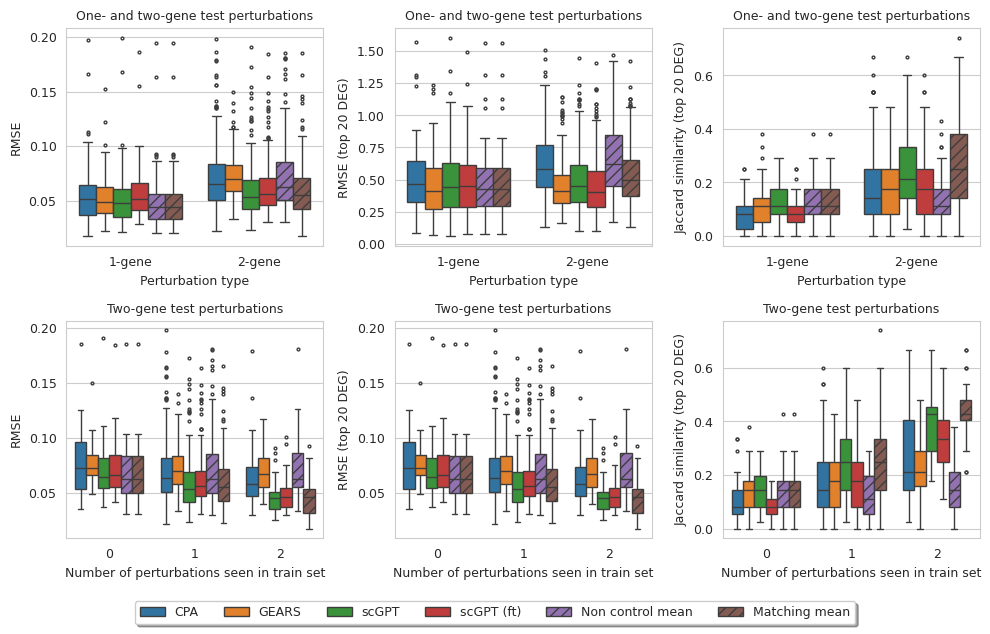

In [597]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
ax = sns.boxplot(data=results_df, x='one gene', y='rmse_all', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
ax = sns.boxplot(data=results_df, x='one gene', y='rmse_20de', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('RMSE (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 3)
ax = sns.boxplot(data=results_df, x='one gene', y='jaccard', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='rmse_all', hue='method',
            fliersize=fliersize,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 5)
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='rmse_all', hue='method',
            fliersize=fliersize,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('RMSE (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 6)
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='jaccard', hue='method',
            fliersize=fliersize,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=fontsize)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_rmse_combined.pdf', bbox_inches='tight');

## Reference: Centroid of all perturbed cells

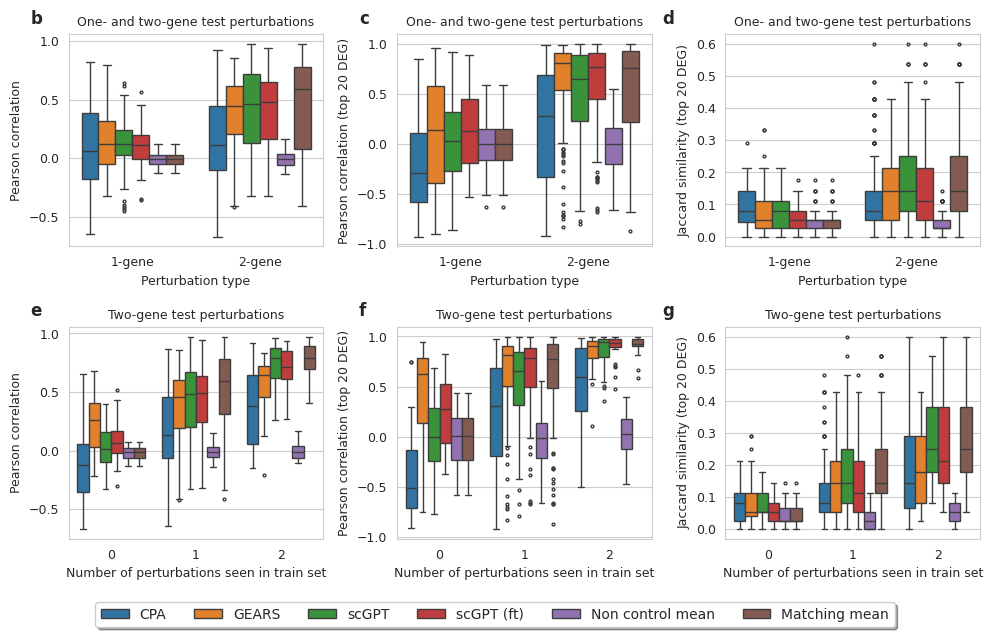

In [168]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.15, 1.05, 'b')
sns.boxplot(data=results_df, x='one gene', y='corr_all_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.15, 1.05, 'c')
sns.boxplot(data=results_df, x='one gene', y='corr_20de_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1.05, 'd')
sns.boxplot(data=results_df, x='one gene', y='jaccard_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
letter_annotation(plt.gca(), -.15, 1.05, 'e')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all_allpert', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 5)
letter_annotation(plt.gca(), -.15, 1.05, 'f')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_20de_allpert', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 6)
letter_annotation(plt.gca(), -.25, 1.05, 'g')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='jaccard_allpert', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=6)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_pearsondiff_allpert_combined.pdf', bbox_inches='tight');

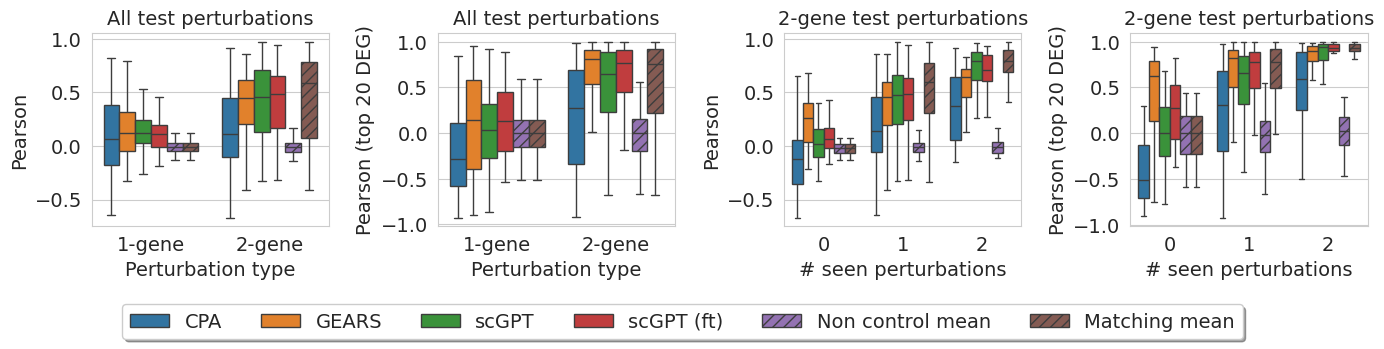

In [561]:
nrows = 1
ncols = 4
fontsize = 14
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(14, 3))
plt.subplot(nrows, ncols, 1)
# letter_annotation(plt.gca(), -.25, 1, 'a')
ax = sns.boxplot(data=results_df, x='one gene', y='corr_all_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
# letter_annotation(plt.gca(), -.25, 1, 'b')
ax = sns.boxplot(data=results_df, x='one gene', y='corr_20de_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 3)
# letter_annotation(plt.gca(), -.25, 1, 'd')
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all_allpert', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
# letter_annotation(plt.gca(), -.25, 1, 'e')
ax = sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_20de_allpert', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=14)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_pearsondiff_allpert_combined_2.pdf', bbox_inches='tight');

In [721]:
results_df_ = results_df[(results_df['method'] != 'matching-mean') | (results_df['one gene'] != '1-gene')]
results_df_

,method,pert,seed,corr_all,corr_20de,corr_all_allpert,corr_20de_allpert,corr_all_twopert,corr_20de_twopert,mse_all,mse_20de,mse_all_allpert,mse_20de_allpert,jaccard,jaccard_allpert,one gene,train
0,cpa,ctrl+PRTG,1,0.285728,0.834513,-0.026482,-0.592166,0.126454,-0.684675,0.003363,0.393248,0.003363,0.393248,0.081081,0.052632,1-gene,0
1,cpa,ctrl+CEBPB,1,-0.085036,-0.597240,-0.338543,-0.459582,-0.208687,-0.277457,0.009345,0.656898,0.009345,0.656898,0.052632,0.081081,1-gene,0
2,cpa,FOXL2+ctrl,1,-0.140066,-0.392309,-0.042920,-0.066710,0.283446,0.264992,0.002628,0.178753,0.002628,0.178753,0.052632,0.142857,1-gene,0
3,cpa,ZC3HAV1+HOXC13,1,0.369024,0.881232,0.016662,-0.517107,0.281400,-0.401673,0.002367,0.202887,0.002367,0.202887,0.111111,0.081081,2-gene,2
4,cpa,CDKN1B+CDKN1A,1,0.162853,0.695015,-0.365502,-0.731749,-0.212752,-0.679249,0.005762,0.386016,0.005762,0.386016,0.111111,0.111111,2-gene,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,matching-mean,UBASH3B+ZBTB25,3,0.923274,0.976585,0.629374,0.850231,0.530212,0.535038,0.002720,0.319493,0.002720,0.319493,0.428571,0.142857,2-gene,1
1994,matching-mean,KLF1+CLDN6,3,0.831168,0.775618,0.485902,0.590206,0.342976,0.447163,0.004434,0.509404,0.004434,0.509404,0.428571,0.290323,2-gene,1
1995,matching-mean,FOSB+UBASH3B,3,0.543401,0.616267,0.274215,-0.492909,0.616629,-0.148789,0.000955,0.080871,0.000955,0.080871,0.000000,0.000000,2-gene,0
1996,matching-mean,CEBPB+OSR2,3,0.954270,0.974969,0.897827,0.960936,0.892595,0.950959,0.002078,0.123851,0.002078,0.123851,0.481481,0.428571,2-gene,2


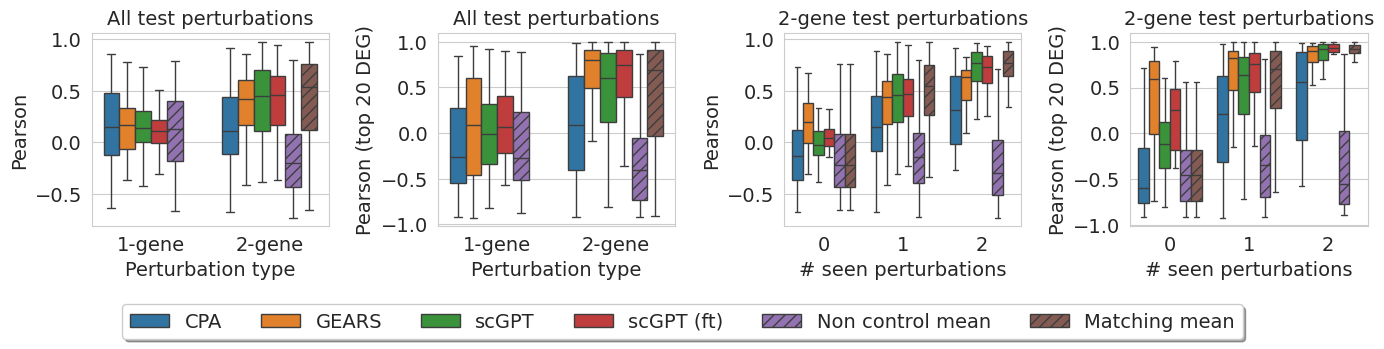

In [722]:
nrows = 1
ncols = 4
fontsize = 14
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(14, 3))
plt.subplot(nrows, ncols, 1)
# letter_annotation(plt.gca(), -.25, 1, 'a')
ax = sns.boxplot(data=results_df_, x='one gene', y='corr_all_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
# print(ax), [results_df['method'] != 'matching-mean']
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
# letter_annotation(plt.gca(), -.25, 1, 'b')
ax = sns.boxplot(data=results_df_, x='one gene', y='corr_20de_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 3)
# letter_annotation(plt.gca(), -.25, 1, 'd')
ax = sns.boxplot(data=results_df_[results_df_['one gene'] == '2-gene'], x='train', y='corr_all_allpert', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
# letter_annotation(plt.gca(), -.25, 1, 'e')
ax = sns.boxplot(data=results_df_[results_df_['one gene'] == '2-gene'], x='train', y='corr_20de_allpert', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=14)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_pearsondiff_allpert_combined_3.pdf', bbox_inches='tight');

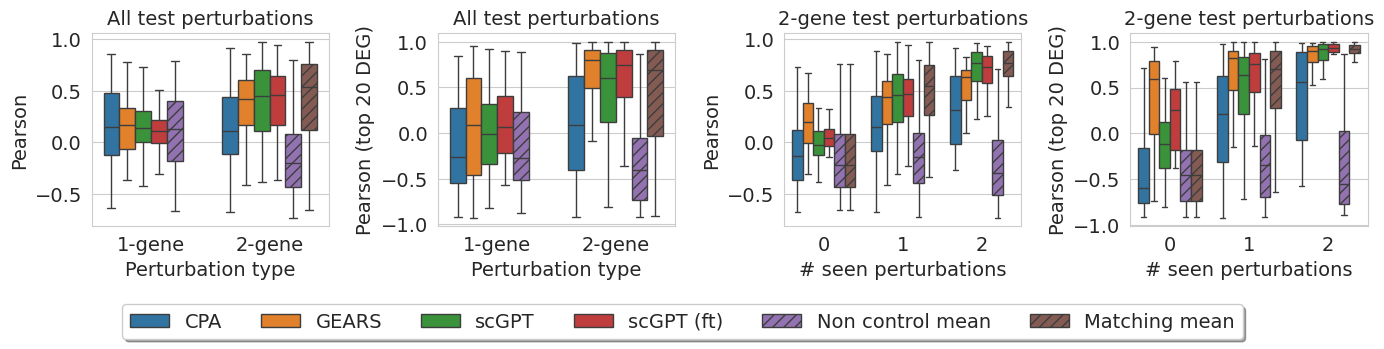

In [730]:
nrows = 1
ncols = 4
fontsize = 14
fliersize = 2
showfliers = False
fig = plt.figure(figsize=(14, 3))
plt.subplot(nrows, ncols, 1)
# letter_annotation(plt.gca(), -.25, 1, 'a')
ax = sns.boxplot(data=results_df_, x='one gene', y='corr_all_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
# print(ax), [results_df['method'] != 'matching-mean']
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
# letter_annotation(plt.gca(), -.25, 1, 'b')
ax = sns.boxplot(data=results_df_, x='one gene', y='corr_20de_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            showfliers=showfliers,
            order=['1-gene', '2-gene'])
hatches = ["", "", "", "", "", "", "", "", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('All test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 3)
# letter_annotation(plt.gca(), -.25, 1, 'd')
ax = sns.boxplot(data=results_df_[results_df_['one gene'] == '2-gene'], x='train', y='corr_all_allpert', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
# letter_annotation(plt.gca(), -.25, 1, 'e')
ax = sns.boxplot(data=results_df_[results_df_['one gene'] == '2-gene'], x='train', y='corr_20de_allpert', hue='method',
            fliersize=fliersize,
            showfliers=showfliers,
            hue_order=methods)
hatches = ["", "", "", "", "", "", "", "", "", "", "", "",  "///", "///", "///", "///", "///", "///"]
patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
h = hatches
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('2-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('# seen perturbations', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                    fancybox=True, shadow=True, ncol=6, fontsize=14)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
    
hatches = ["", "", "", "", "///", "///"]
for lp, hatch in zip(legend.get_patches(), hatches):
    lp.set_hatch(hatch)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
# plt.savefig(f'{figdir}/{dataset}_pearsondiff_allpert_combined_3.pdf', bbox_inches='tight');

### Reference: Centroid of all two perturbation

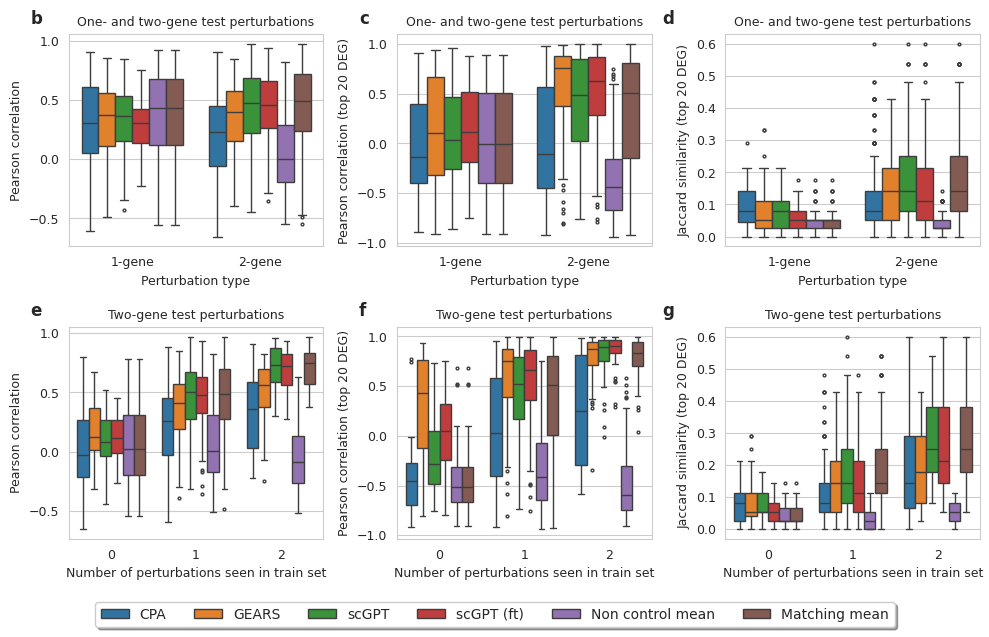

In [479]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.15, 1.05, 'b')
sns.boxplot(data=results_df, x='one gene', y='corr_all_twopert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.15, 1.05, 'c')
sns.boxplot(data=results_df, x='one gene', y='corr_20de_twopert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1.05, 'd')
sns.boxplot(data=results_df, x='one gene', y='jaccard_allpert', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
letter_annotation(plt.gca(), -.15, 1.05, 'e')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all_twopert', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 5)
letter_annotation(plt.gca(), -.15, 1.05, 'f')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_20de_twopert', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 6)
letter_annotation(plt.gca(), -.25, 1.05, 'g')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='jaccard_allpert', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=6)

labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
# plt.savefig(f'{figdir}/{dataset}_pearsondiff_allpert_combined.pdf', bbox_inches='tight');

#### Cumulative performance sorting perturbations by alignment with average treatment effect

In [20]:
df, df_pair, df_norm, pert_names = compute_shift_similarities(adata)

In [244]:
df_ = df[df['variable'] == 'avg_ctl'].sort_values(by='value', ascending=False).set_index('pert_names')
df_norm_ = df_norm[df_norm['variable'] == 'avg_ctl'].sort_values(by='value', ascending=False).set_index('pert_names')
df_['value'].mean()

0.5025768

In [237]:
def plot_performance(results_df_, df_, metric, xlabel='Number of 1-gene test perturbations', ylabel='Pearson correlation (top 20 DEGs)'):
    # Calculate scores
    unique_test_perts = results_df_['pert'].unique()
    sorted_test_perts_df = df_.loc[unique_test_perts].sort_values(by='value', ascending=False)
    discard_perts = []
    scores_df = pd.DataFrame()
    mean_cossims = []
    for i, p in tqdm(enumerate(sorted_test_perts_df[sorted_test_perts_df['value'] > 0].index)): 
        res_df = results_df_[~results_df_['pert'].isin(discard_perts)]
        score = res_df[[metric, 'method']].groupby('method').mean()
        scores_df[i] = score
        mean_cossim = sorted_test_perts_df[~sorted_test_perts_df.index.isin(discard_perts)]['value'].mean()
        mean_cossims.append(mean_cossim)
        discard_perts.append(p)
        
    # Plot
    scores_df_ = scores_df[scores_df.index != 'matching-mean']
    # plt.imshow(np.array(mean_cossims).reshape(1, -1))
    ax = plt.gca()
    sns.lineplot(data=scores_df_.T, ax=ax)
    n = len(mean_cossims) # len(results_df_[results_df_['method'] == 'nonctl-mean'])
    idxs = np.arange(n // 10 + 1)
    ax.set_xticks(idxs*10, len(sorted_test_perts_df)-10*idxs) # .set_xticks(idxs, n-idxs)

    # Create a gradient background using imshow
    # Generate a gradient array
    gradient = np.array(mean_cossims).reshape(1, -1)  # Horizontal gradient
    gradient = np.vstack([gradient]*256)  # Stack it to fill the background

    # Display the gradient image behind the plot
    img = ax.imshow(gradient, extent=[0, len(mean_cossims)+1, ax.get_ylim()[0], ax.get_ylim()[1]],
                    aspect='auto', cmap='coolwarm', alpha=0.2, zorder=0)
    # cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
    # cbar.set_label('Gradient Intensity')
    secax = ax.secondary_xaxis("top")
    idxs = np.arange(n // 10 + 1)
    # secax.set_ticks(idxs*10, [f'{s:.2f}' for s in np.array(mean_cossims)[10*idxs]])
    secax.set_xlabel('Average cosine similarity')

    # plt.grid(axis='x', visible=False)
    plt.grid(False)
    idxs = []
    poss = [0.4, 0.3, 0.2, 0.1, 0]
    for pos in poss:
        idx = (np.abs(np.array(mean_cossims) - pos)).argmin()  # find_nearest(mean_cossims, pos)
        idxs.append(idx)
        ax.axvline(x=idx, color='grey', linestyle='--', linewidth=0.4, alpha=0.5, zorder=1)
    secax.set_xticks(idxs, poss) # .set_xticks(idxs, n-idxs)

    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    legend = plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=6)
    labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
    for i, label in enumerate(labels):
        legend.get_texts()[i].set_text(label)
    plt.tight_layout()

    plt.ylabel(ylabel)
    plt.xlabel(xlabel);
    
    return scores_df_

85it [00:00, 506.23it/s]


,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
method,,,,,,,,,,,,,,,,,,,,,
cpa,0.207385,0.204488,0.207741,0.208364,0.208676,0.210750,0.210603,0.211835,0.208173,0.211213,...,0.036489,0.023337,0.039121,0.055599,0.075620,0.074136,0.077109,0.046277,0.050923,0.027202
gears,0.414381,0.412279,0.410386,0.408728,0.407920,0.406531,0.405714,0.403738,0.402290,0.400314,...,0.104019,0.097393,0.092816,0.088554,0.071067,0.042899,0.005254,-0.016783,-0.040784,-0.074457
nonctl-mean,0.485867,0.483384,0.480535,0.478053,0.474941,0.472566,0.469416,0.466897,0.464150,0.461172,...,0.033559,0.018934,0.004524,-0.010358,-0.027706,-0.048541,-0.075929,-0.087689,-0.129724,-0.178756
scgpt,0.401871,0.399727,0.399134,0.398055,0.396088,0.394569,0.392502,0.389828,0.390196,0.389731,...,0.083142,0.078401,0.067448,0.055172,0.039341,0.000815,-0.052847,-0.051865,-0.085552,-0.147956
scgpt_ft,0.357482,0.355819,0.354938,0.352493,0.350440,0.348336,0.346113,0.346577,0.345829,0.344750,...,0.047371,0.037424,0.023681,0.006631,-0.009498,-0.028113,-0.057215,-0.054581,-0.083154,-0.138047


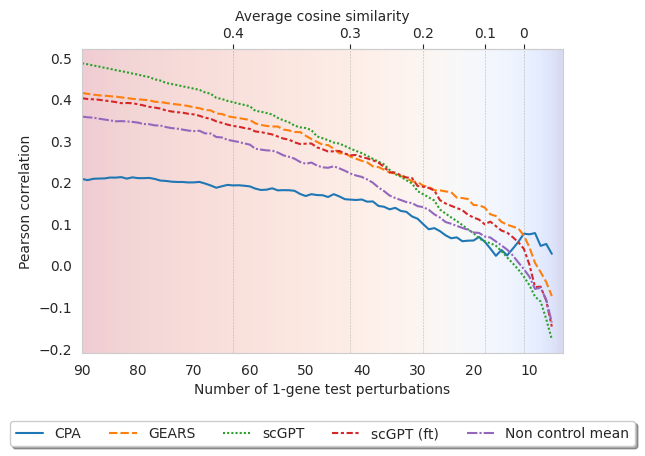

In [238]:
metric = 'corr_all' # 'corr_20de' # 'corr_20de'
results_df_ = results_df[results_df['one gene'] == '1-gene']
plot_performance(results_df_, df_, metric, ylabel='Pearson correlation')

85it [00:00, 552.77it/s]


,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
method,,,,,,,,,,,,,,,,,,,,,
cpa,0.341272,0.335751,0.342516,0.340989,0.342273,0.343486,0.343621,0.343620,0.338341,0.342217,...,-0.014455,-0.020804,0.016065,0.061672,0.102756,0.127789,0.168046,0.113442,0.137188,0.084246
gears,0.591249,0.588427,0.585510,0.582520,0.582552,0.580642,0.580053,0.576934,0.574454,0.571651,...,0.064257,0.076303,0.111495,0.152436,0.112070,0.097546,0.079541,0.064774,0.078248,0.026901
nonctl-mean,0.520382,0.516727,0.513160,0.509112,0.505146,0.501913,0.497674,0.493655,0.489982,0.486017,...,-0.259554,-0.254169,-0.243815,-0.232836,-0.245383,-0.215768,-0.180652,-0.150281,-0.171700,-0.266451
scgpt,0.438455,0.434343,0.434270,0.430258,0.428018,0.424064,0.421418,0.417165,0.419546,0.419822,...,-0.005542,0.011747,0.031773,0.056963,0.042145,0.013630,-0.032339,0.027232,0.008294,-0.140540
scgpt_ft,0.468832,0.466815,0.467485,0.464218,0.460050,0.456575,0.452020,0.452209,0.449872,0.449356,...,0.091952,0.132617,0.102422,0.064044,0.044837,0.031751,0.002973,0.065167,0.085076,-0.035822


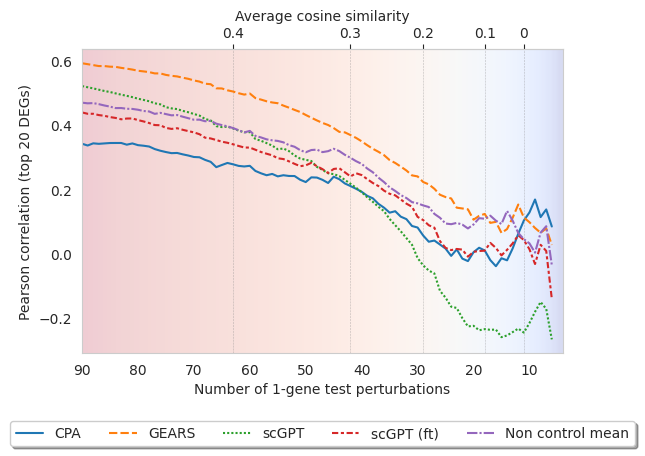

In [239]:
metric = 'corr_20de'
results_df_ = results_df[results_df['one gene'] == '1-gene']
plot_performance(results_df_, df_, metric, ylabel='Pearson correlation (top 20 DEGs)')

85it [00:00, 542.18it/s]


,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
method,,,,,,,,,,,,,,,,,,,,,
cpa,0.508306,0.507034,0.503428,0.503771,0.496143,0.496405,0.489212,0.488876,0.488283,0.486053,...,0.480316,0.498691,0.485368,0.474637,0.450310,0.391697,0.309883,0.288609,0.253374,0.275101
gears,0.446867,0.445441,0.443791,0.444604,0.436986,0.437559,0.430335,0.430634,0.429571,0.429118,...,0.474801,0.490219,0.477967,0.468539,0.452321,0.402677,0.333151,0.310913,0.276954,0.302469
nonctl-mean,0.466340,0.465356,0.462716,0.463953,0.457600,0.458545,0.452650,0.453258,0.452537,0.451197,...,0.513875,0.531741,0.522071,0.515342,0.495749,0.439980,0.361840,0.331974,0.302105,0.331192
scgpt,0.477156,0.476191,0.472898,0.473489,0.466767,0.468180,0.461923,0.462592,0.460703,0.458640,...,0.495740,0.511673,0.502248,0.495721,0.477700,0.426070,0.354876,0.324345,0.293490,0.332127
scgpt_ft,0.473827,0.472554,0.469341,0.470491,0.464696,0.466001,0.460617,0.460173,0.458724,0.456986,...,0.506124,0.521429,0.516128,0.515125,0.499685,0.453654,0.389945,0.358465,0.311185,0.350003


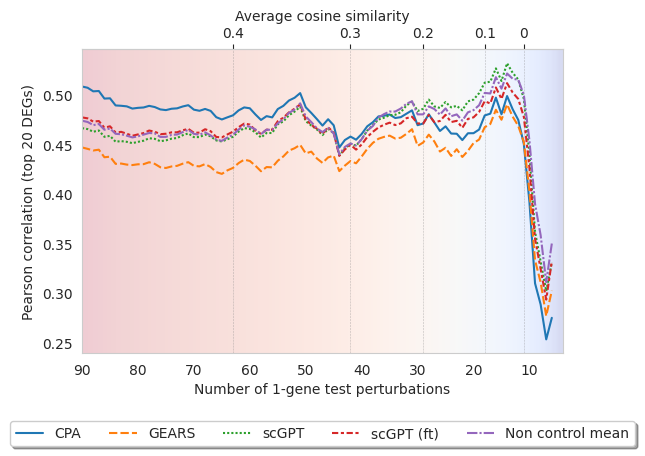

In [240]:
metric = 'rmse_20de'
results_df_ = results_df[results_df['one gene'] == '1-gene']
plot_performance(results_df_, df_, metric, ylabel='Pearson correlation (top 20 DEGs)')

Text(0, 0.5, 'Alignment with systematic variation (cosine similarity)')

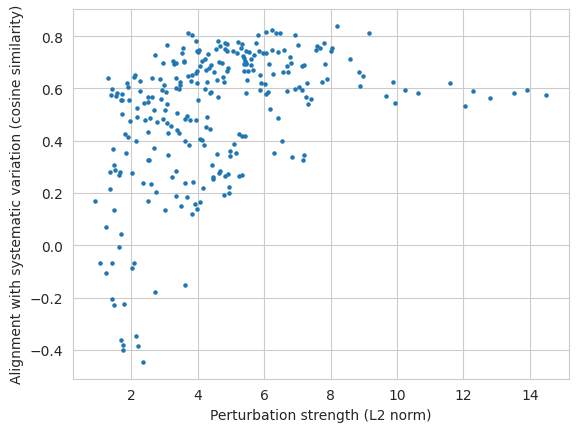

In [255]:
merged_df = df_.merge(df_norm_, left_index=True, right_index=True, suffixes=('_cossim', '_l2'))
plt.scatter(merged_df['value_l2'], merged_df['value_cossim'], s=5)
plt.xlabel('Perturbation strength (L2 norm)')
plt.ylabel('Alignment with systematic variation (cosine similarity)')

#### Perturbation plot

In [614]:
query = 'ETS2+IKZF3' # 'CDKN1B+CDKN1A'   # 'FOSB+CEBPB' # 'FOXA3+FOXF1'  # 'CEBPE+CEBPA' # 'FOSB+CEBPB' # 'CDKN1B+CDKN1A' # 'FOXA3+FOXF1'
# method = 'gears'  # 'matching-mean'
seed = 2

In [615]:
gene2idx = {x: it for it, x in enumerate(adata.var.gene_name)}
cond2name = dict(adata.obs[['condition', 'condition_name']].values)
gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))
de_idx = [gene2idx[gene_raw2id[i]] for i in
          adata.uns['top_non_dropout_de_20'][cond2name[query]]]
genes = [gene_raw2id[i] for i in
         adata.uns['top_non_dropout_de_20'][cond2name[query]]]
de_idx = de_idx
train_adata = adata[adata.obs['split'] == 'train']
control_adata = train_adata[train_adata.obs['control'] == 1]
pert_adata = train_adata[train_adata.obs['control'] == 0]
control_mean = np.array(control_adata.X.mean(axis=0))[0]
pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
control_mean = np.array(control_adata.X.mean(axis=0))[0]

# Get sample
post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
post_pred_df.loc[query]

,RP11-34P13.8,RP11-54O7.3,SAMD11,PERM1,HES4,ISG15,RP11-54O7.18,RNF223,LINC01342,TTLL10-AS1,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC136616.1,AC023491.2
n_train,,,,,,,,,,,,,,,,,,,,,
0,0.00009,0.005411,0.015072,0.000159,0.20026,0.326256,0.000025,0.005691,0.0,0.000599,...,4.06041,5.161668,3.543109,1.157955,4.482299,2.105359,1.460148,3.716571,0.001126,0.0


In [616]:
post_gt_df[post_gt_df.index.get_level_values(1) == 0]

,,RP11-34P13.8,RP11-54O7.3,SAMD11,PERM1,HES4,ISG15,RP11-54O7.18,RNF223,LINC01342,TTLL10-AS1,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC136616.1,AC023491.2
condition,n_train,,,,,,,,,,,,,,,,,,,,,
FOXA1+ctrl,0,0.000000,0.007641,0.006860,0.000000,0.175811,0.267941,0.0,0.001460,0.00000,0.000000,...,4.099123,5.195217,3.526990,1.249325,4.538897,2.177996,1.344293,3.719458,0.000000,0.000000
CNN1+ctrl,0,0.000000,0.006941,0.000000,0.000000,0.165711,0.247915,0.0,0.000000,0.00000,0.000000,...,4.127567,5.228150,3.575379,1.216447,4.555939,2.192273,1.546977,3.801392,0.000000,0.000000
FOSB+ctrl,0,0.000000,0.013063,0.007239,0.000000,0.232258,0.348167,0.0,0.000000,0.00000,0.000000,...,4.084805,5.120902,3.603524,1.320666,4.484684,2.184969,1.641779,3.730557,0.002325,0.000000
ctrl+MAPK1,0,0.000000,0.000000,0.009053,0.000000,0.249213,0.644917,0.0,0.000000,0.00000,0.005005,...,3.957164,5.051389,3.438083,1.094162,4.492835,2.067970,1.277781,3.656707,0.000000,0.000000
GLB1L2+ctrl,0,0.000000,0.003138,0.006043,0.000000,0.180320,0.342556,0.0,0.000000,0.00000,0.000000,...,4.157234,5.224566,3.583322,1.254690,4.569389,2.174130,1.554406,3.798108,0.004445,0.000000
HES7+ctrl,0,0.000000,0.000000,0.005625,0.000000,0.101726,0.162285,0.0,0.000000,0.00000,0.000000,...,4.060214,5.120628,3.609672,0.990774,4.467969,2.055103,1.157070,3.865061,0.000000,0.000000
MAP2K3+IKZF3,0,0.000000,0.000000,0.002185,0.000000,0.190676,0.320781,0.0,0.000000,0.00000,0.000000,...,4.039144,5.125372,3.543973,1.038026,4.465456,2.059790,1.312742,3.698228,0.000000,0.000000
FOXL2+ctrl,0,0.000000,0.010060,0.018433,0.000000,0.184974,0.358027,0.0,0.000000,0.00000,0.000000,...,4.029155,5.145072,3.551042,1.190468,4.494837,2.131362,1.475707,3.702066,0.006440,0.000000
ctrl+ISL2,0,0.000000,0.000000,0.014335,0.000000,0.195905,0.325107,0.0,0.000000,0.00000,0.000000,...,4.058105,5.151796,3.527724,1.233507,4.517388,2.122201,1.480813,3.735661,0.000000,0.000000


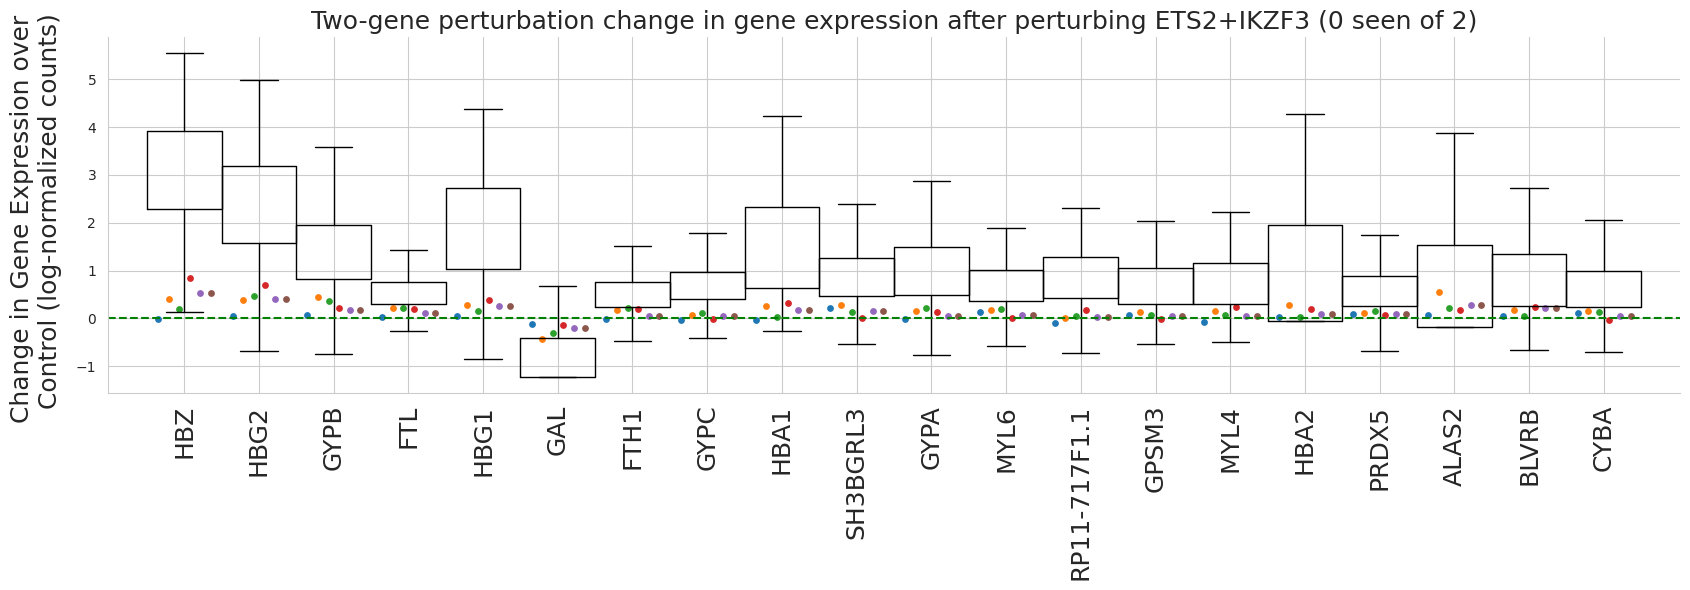

In [617]:
post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
ctrl_means = control_mean[de_idx]
truth = truth - ctrl_means

fig = plt.figure(figsize=(17, 6))
margin = 0.15
fontsize = 18
cmap = plt.get_cmap('tab10')
n_seen = post_gt_df.loc[query].index.values[0]
plt.title(f'Two-gene perturbation change in gene expression after perturbing {query} ({n_seen} seen of 2)', fontsize=fontsize)
plt.boxplot(truth, showfliers=False, medianprops = dict(linewidth=0), widths=1)  
for j, method in enumerate(methods):
    # Get methods predictions
    post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
    pred = post_pred_df.loc[query].values[:, de_idx].flatten()
    pred = pred - ctrl_means

    spacing = (1 - margin) / len(methods)
    for i in range(pred.shape[0]):
        label = None
        if i == 0:
            label = method
        _ = plt.scatter(i+j*spacing + margin + 0.5, pred[i], color=cmap(j), label=label, s=15)
    
# Plot details
plt.axhline(0, linestyle="dashed", color = 'green')
ax = plt.gca()
ax.xaxis.set_ticklabels(genes, rotation = 90, fontsize=fontsize)

if n_seen == 2:
    legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                        fancybox=True, shadow=True, fontsize=fontsize, ncol=6)

plt.ylabel("Change in Gene Expression over \n Control (log-normalized counts)", labelpad=10, fontsize=fontsize)
plt.tick_params(axis='x', which='major', pad=5)
plt.tick_params(axis='y', which='major', pad=5)
plt.xlim((-0.02, len(de_idx)+1.02))
sns.despine()
plt.tight_layout()
plt.savefig(f'{figdir}/{dataset}_box_{query}_nseen{n_seen}_seed{seed}.pdf', bbox_inches='tight');

#### In-text results

In [732]:
df = results_df[results_df['one gene'] == '1-gene']
n = len(df)
groupby = df.groupby('method')[['corr_all', 'corr_20de']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n//6), groupby.count()

(               corr_all  corr_20de
 method                            
 cpa            0.207385   0.341272
 gears          0.414381   0.591249
 matching-mean  0.485867   0.520382
 nonctl-mean    0.485867   0.520382
 scgpt          0.401871   0.438455
 scgpt_ft       0.357482   0.468832,
                corr_all  corr_20de
 method                            
 cpa            0.224534   0.460241
 gears          0.203078   0.341379
 matching-mean  0.248601   0.449876
 nonctl-mean    0.248601   0.449876
 scgpt          0.209585   0.397217
 scgpt_ft       0.204751   0.382669,
                corr_all  corr_20de
 method                            
 cpa            0.021606   0.044287
 gears          0.019541   0.032849
 matching-mean  0.023922   0.043289
 nonctl-mean    0.023922   0.043289
 scgpt          0.020167   0.038222
 scgpt_ft       0.019702   0.036822,
                corr_all  corr_20de
 method                            
 cpa                 108        108
 gears               108 

In [733]:
df = results_df[results_df['one gene'] == '1-gene']
n = len(df)
groupby = df.groupby('method')[['corr_all_allpert', 'corr_20de_allpert']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n//6), groupby.count()

(               corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.147827          -0.165010
 gears                  0.159217           0.066183
 matching-mean          0.102090          -0.167714
 nonctl-mean            0.102090          -0.167714
 scgpt                  0.135856          -0.014533
 scgpt_ft               0.108346           0.103201,
                corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.369772           0.497673
 gears                  0.268721           0.554884
 matching-mean          0.369124           0.472650
 nonctl-mean            0.369124           0.472650
 scgpt                  0.253087           0.433997
 scgpt_ft               0.171808           0.373277,
                corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.035581           0.047889
 gears    

In [734]:
df = results_df[results_df['one gene'] == '2-gene']
n = len(df)
groupby = df.groupby('method')[['corr_all', 'corr_20de']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n//6), groupby.count()

(               corr_all  corr_20de
 method                            
 cpa            0.479309   0.669185
 gears          0.596199   0.786277
 matching-mean  0.733326   0.833470
 nonctl-mean    0.559017   0.669028
 scgpt          0.654758   0.751972
 scgpt_ft       0.606816   0.789364,
                corr_all  corr_20de
 method                            
 cpa            0.272371   0.320980
 gears          0.208715   0.258612
 matching-mean  0.236054   0.265149
 nonctl-mean    0.217140   0.339370
 scgpt          0.243129   0.266606
 scgpt_ft       0.240093   0.249871,
                corr_all  corr_20de
 method                            
 cpa            0.018158   0.021399
 gears          0.013914   0.017241
 matching-mean  0.015737   0.017677
 nonctl-mean    0.014476   0.022625
 scgpt          0.016209   0.017774
 scgpt_ft       0.016006   0.016658,
                corr_all  corr_20de
 method                            
 cpa                 225        225
 gears               225 

In [735]:
df = results_df[results_df['one gene'] == '2-gene']
n = len(df)
groupby = df.groupby('method')[['corr_all_allpert', 'corr_20de_allpert']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n//6), groupby.count()

(               corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.146519           0.095563
 gears                  0.369561           0.635386
 matching-mean          0.414607           0.434028
 nonctl-mean           -0.138740          -0.325169
 scgpt                  0.400470           0.448084
 scgpt_ft               0.406285           0.585071,
                corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.369659           0.582128
 gears                  0.290230           0.393547
 matching-mean          0.417549           0.575203
 nonctl-mean            0.365532           0.454552
 scgpt                  0.345581           0.477837
 scgpt_ft               0.299435           0.400865,
                corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.024644           0.038809
 gears    

In [736]:
df = results_df[(results_df['one gene'] == '2-gene') & (results_df['train'] == 0)]
n = len(df)
groupby = df.groupby('method')[['corr_all_allpert', 'corr_20de_allpert']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n//6), groupby.count()

(               corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                   -0.113528          -0.432109
 gears                  0.190245           0.430775
 matching-mean         -0.169432          -0.416106
 nonctl-mean           -0.169432          -0.416106
 scgpt                 -0.008076          -0.125930
 scgpt_ft               0.067562           0.173193,
                corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.310600           0.425893
 gears                  0.258768           0.439656
 matching-mean          0.333399           0.394383
 nonctl-mean            0.333399           0.394383
 scgpt                  0.185405           0.335481
 scgpt_ft               0.159608           0.373719,
                corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.049736           0.068197
 gears    

In [737]:
df = results_df[(results_df['one gene'] == '2-gene') & (results_df['train'] == 1)]
n = len(df)
groupby = df.groupby('method')[['corr_all_allpert', 'corr_20de_allpert']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n//6), groupby.count()

(               corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.167302           0.154968
 gears                  0.373501           0.638870
 matching-mean          0.479584           0.537703
 nonctl-mean           -0.113693          -0.292655
 scgpt                  0.423481           0.495937
 scgpt_ft               0.421772           0.612949,
                corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.352604           0.547747
 gears                  0.286450           0.396495
 matching-mean          0.325933           0.450934
 nonctl-mean            0.373417           0.449524
 scgpt                  0.303073           0.423801
 scgpt_ft               0.265788           0.366284,
                corr_all_allpert  corr_20de_allpert
 method                                            
 cpa                    0.029082           0.045177
 gears    

In [738]:
df = results_df[(results_df['one gene'] == '2-gene') & (results_df['train'] == 2)]
n = len(df)
groupby = df.groupby('method')[['corr_all_allpert', 'corr_20de_allpert', 'jaccard_allpert']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n//6), groupby.count()

(               corr_all_allpert  corr_20de_allpert  jaccard_allpert
 method                                                             
 cpa                    0.328229           0.399327         0.169403
 gears                  0.534028           0.826861         0.189857
 matching-mean          0.753732           0.893387         0.254180
 nonctl-mean           -0.202456          -0.356786         0.121380
 scgpt                  0.722282           0.841729         0.271860
 scgpt_ft               0.686630           0.891872         0.252814,
                corr_all_allpert  corr_20de_allpert  jaccard_allpert
 method                                                             
 cpa                    0.355500           0.518976         0.131997
 gears                  0.231284           0.187137         0.116268
 matching-mean          0.154841           0.116762         0.143433
 nonctl-mean            0.364908           0.521953         0.074433
 scgpt                  0.192512 